In [1]:
# !pip3 install seaborn
# !pip3 install optuna
# !pip3 install plotly

In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import plotly

import gymnasium as gym
import numpy as np
import random
import time
import inspect

import optuna
from optuna.visualization import plot_intermediate_values

# %matplotlib inline - builtin thus not required
from IPython import display

In [3]:
ENV = gym.make("Taxi-v3", render_mode="rgb_array")
N_STATES = ENV.observation_space.n # 25 taxi positions * 5 passenger locations * 4 destinations
N_ACTIONS = ENV.action_space.n
ACTIONS_STR = ('^','v','<','>','p','d') # for taxi

In [4]:
N_STATES, N_ACTIONS

(500, 6)

In [5]:
def rr(env=ENV):
    """quick render fix assuming env's render_mode='rgb_array' """
    # plt.figure(figsize=(5,10))
    plt.axis('off')
    plt.imshow(env.render())
               
def act(action_id: int, env=ENV):
    """filters unnecessary output"""
    return env.step(action_id)[:3]

def rewards(trajectory):
    """plots cumulative reward over given trajectory"""
    plt.figure(figsize=(5,5))
    plt.axis('on')
    plt.plot(np.cumsum(trajectory['r']))
    plt.title('Reward')
    plt.xlabel('Step')

In [6]:
# stochastic init state
ENV.reset()

(462, {'prob': 1.0, 'action_mask': array([0, 1, 1, 0, 0, 0], dtype=int8)})

In [7]:
# deterministic action ^v<> pick drop
new_state = ENV.step(2) # [state, reward, done, info, ...]
new_state, tuple(ENV.decode(new_state[0]))  #state decoded into (taxi_row, taxi_col, passenger_location, destination)

C:\Users\KA\PycharmProjects\DRL_1\venv\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.decode to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.decode` for environment variables or `env.get_wrapper_attr('decode')` that will search the reminding wrappers.
  logger.warn(


((482,
  -1,
  False,
  False,
  {'prob': 1.0, 'action_mask': array([0, 1, 0, 1, 0, 0], dtype=int8)}),
 (4, 4, 0, 2))

In [8]:
act(0)
# rr()

(482, -1, False)

In [35]:
class RandAgent():
    """baseline agent that performs random actions"""
    def __init__(self, n_actions, id_to_str=None):
        self.n_actions = n_actions
        self.id_to_str = id_to_str
        
    def act(self, state):
        action = random.randrange(self.n_actions)
        # print('RANDOM!!')
        return action

    def walk(self, max_length, render=False, **actkwargs):
        """take max_length actions by agent N"""
        states, actions, rewards = [], [], []
        # initialization state
        state = ENV.reset()[0]
        for i in range(max_length):
            # perform an action
            action = self.act(state, **actkwargs)
            new_state, reward, done = act(action)
            # log 
            actions.append(action)
            states.append(state) # append OLD state, everything breaks if you start from new
            rewards.append(reward)
            state = new_state
            # continuos visualization w/ proper interrupt
            if render:
                try:
                    rr()
                    display.display(plt.gcf())
                    display.clear_output(wait=True)
                    time.sleep(0.00001)
                except KeyboardInterrupt:
                    break
            if done:
                break
        trajectory = {'s': states,
                        'a': actions,
                            'r': rewards,}
        return trajectory

In [36]:
# agent = RandAgent(6)
# results = agent.walk(max_length=10, render=True)
# ax = rewards(results)

In [55]:
class CrossEntropyAgent(RandAgent):
    def __init__(self, n_states, n_actions, id_to_str):
        """CrossEntropy algorithm actor, optimizes expected reward by policy"""
        super().__init__(n_actions, id_to_str)
        self.n_states = n_states
        # policy matrix shaped (state, action "probability')
        self.sa = np.ones((n_states, self.n_actions))/self.n_actions
        self.log = []
        self.hp = {}

    def sample_dp(self, on=True):
        """sample deterministic policy from self.sa via inverse transform approach"""
        if on:
            u = np.random.rand(self.sa.shape[0]) # vector with values uniformly-distributed within [0..1)
            idx = (self.sa.cumsum(axis=1) < np.expand_dims(u, -1)).sum(axis=1) - 1 # action indices, sampled from policy
            # convert those indices to one-hot rows
            sdp = np.zeros_like(self.sa)
            sdp[np.arange(self.n_states), idx] = 1 
            return sdp
        else:
            return None

    def act(self, state, ext_policy=None):
        """random sample from current distribution on actions"""
        action = np.random.choice(self.n_actions, p=self.sa[state] if ext_policy is None else ext_policy[state])
        return action

    def get_policy(self, label=None, ax=None):
        """plots policy matrix as a heatmap"""
        plt.figure(figsize=(3,6))
        concise_actions = {'xticklabels': self.id_to_str} if self.id_to_str else {}
        sns.heatmap(self.sa, **concise_actions)
        plt.title(label if label else 'Current policy')
        return ax

    def learning_curve(self, show_max=True, ax=None):
        """plots rewards vs iterations of algorithm"""
        clr, cla = self.hp['lr'], self.hp['la']
        ax = sns.lineplot(self.log, linewidth=1.0, ax=ax, label=f"lr={round(clr, 2) if clr else clr}, la={round(cla, 2) if cla else cla}")
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.set_title(f"Mean reward over {self.hp['n_trajectories']} trajectories of length < {self.hp['max_length']}", fontsize = 10)
        ax.set_xlabel('iterations - 1')
        ax.set_yscale('symlog')
        ax.legend()
        if show_max:
            ax.axhline(y=max(self.log), color='r', linestyle='-', linewidth=0.5)
        return ax
        
    def fit(self, n_iterations, n_trajectories=100, max_length=50, q=0.8, la=None, lr=None, n_det=0, verbose=None):
        """
        CE Algorithm has 2 steps per iteration: evaluate policy, improve policy
        Our goal is to maximize expected reward ER which is unreachable => approximated
        
        n_trajectories (length <= max_length) defines quality of ER approximation
        0<q<1 controls rejected quantile of trajectories
        
        la>0 controls (and enables) Laplace policy smoothing
        lr>0 controls (and enables) exponential policy smoothing (interpreted as learning rate)

        n_det controls number of deterministic policies sampled to deal with (possibly) stochastic env

        verbose>0 sets up a period of learning process rendering

        NB: .fit internally uses .act method of child class(this), doesn't inherit parental
        """
        # save hyperparameters for comparison
        ap = locals()
        self.hp = {k: ap[k] for k in ap.keys() - ['self', 'verbose', 'n_iterations']}
        for i in range(n_iterations):
            # policy evaluation (act with current policy or sample n_det deterministic from that one)
            trajectories = [self.walk(max_length=max_length, ext_policy=self.sample_dp(k)) for k in range(n_det + 1) for t in range(n_trajectories)]
            rewards = np.stack([np.sum(t['r']) for t in trajectories])
            lengths = np.stack([len(t['r']) for t in trajectories])
            # print(np.max(lengths), np.mean(lengths))
            avg_reward = np.mean(rewards)
            self.log.append(avg_reward)
            # policy improvement
            # get q-quantile of current reward distribution and filter out better trajectories
            # q = 0.5*(1 + q/(1 + np.exp(-i/40))) # variable quantile 0.5...1+q/2
            gamma = np.quantile(rewards, q)
            elite_ids = (rewards > gamma).nonzero()[0]
            # redistribute actions at each state according to these results (put higher weights)
            if elite_ids.any():
                dummy = np.zeros_like(self.sa)
                for ei in elite_ids:
                    et = trajectories[ei]
                    # count number of occurrences for all pairs s-a, all trajectories
                    dummy[et['s'], et['a']] += 1
                occurrences_of_states = dummy.sum(axis=1, keepdims=True)
                occurrences_of_states[occurrences_of_states==0] = 1E-10 # prevent zero division error
                # involves broadcasting, la or lr turn on smoothing if provided
                new_policy = (dummy + la)/(occurrences_of_states + la*self.n_actions) if la else dummy/occurrences_of_states
                sa_ = lr*new_policy + (1-lr)*self.sa if lr else new_policy + self.sa
                # normalize (make new rows sum up to 1)
                self.sa = sa_/sa_.sum(axis=1, keepdims=True)
                
            # visualization
            if verbose and i > 0 and (i + 1) % verbose == 0:
                # print(f"iteration {i + 1}, mean total reward: {avg_reward}")
                plt.close() # because plt.clf() is spurious
                figure, axes = plt.subplots(1, 2, figsize=(10,5))
                self.learning_curve(ax=axes[0])
                ax = sns.histplot(rewards, kde=False, bins=20, ax=axes[1])
                ax.axvline(gamma, 0, 20, color='r')
                ax.set_xlabel('Rewards')
                ax.set_title(f'Current distribution of rewards and its {q:.2f}-quantile ', fontsize = 10)
                
                # self.get_policy(label=f"Agent's policy after {i+1} iterations")

                display.display(plt.gcf())
                display.clear_output(wait=True)
        return avg_reward

In [56]:
def objective(trial):
    """objective for optuna hyperparameter optimization"""
    hyperparameters = {
        'n_trajectories': trial.suggest_int('n_trajectories', 200, 1000, step=100),
        "max_length": trial.suggest_int('max_length', 200, 1000, step=50),
        'q': trial.suggest_float('q', 0.5, 0.9, step=0.1),
        'lr': trial.suggest_float('lr', 0.5, 0.9, step=0.1),
    }
    ce_agent = CrossEntropyAgent(N_STATES, N_ACTIONS, ACTIONS_STR)
    return ce_agent.fit(n_iterations=25, **hyperparameters, verbose=20)

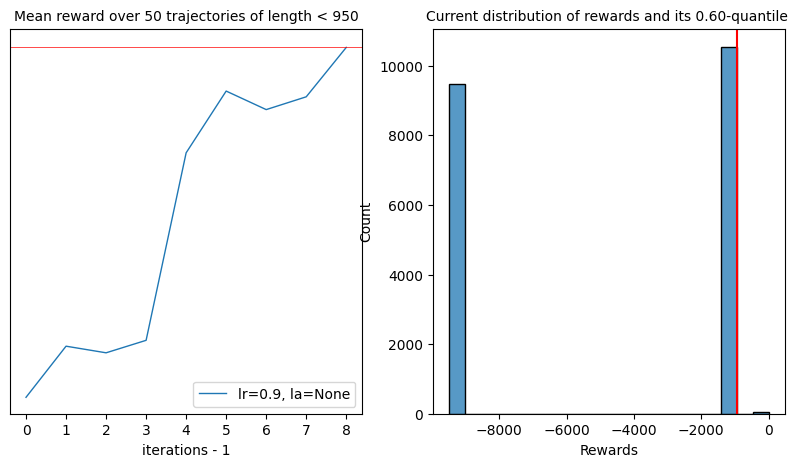

In [ ]:
ce_agent_base = CrossEntropyAgent(N_STATES, N_ACTIONS, ACTIONS_STR)
hp = {'n_trajectories': 50, 'max_length': 950, 'q': 0.6}
ce_agent_base.fit(n_iterations=40, **hp, verbose=1, n_det=400, lr=0.9)

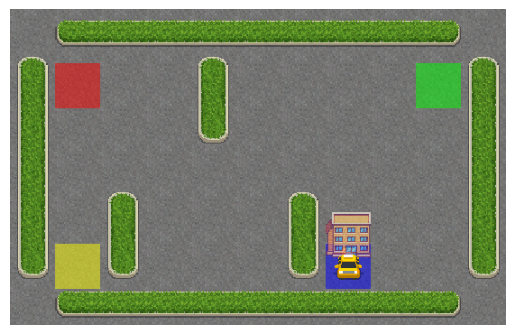

In [300]:
xxx = ce_agent_base.walk(max_length=40, render=True)

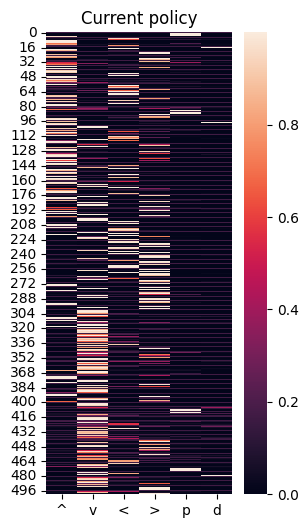

In [301]:
ce_agent_base.get_policy()

[I 2023-10-14 05:25:07,927] Trial 49 finished with value: -2835.04 and parameters: {'n_trajectories': 800, 'max_length': 950, 'q': 0.7, 'lr': 0.8}. Best is trial 48 with value: -152.58.


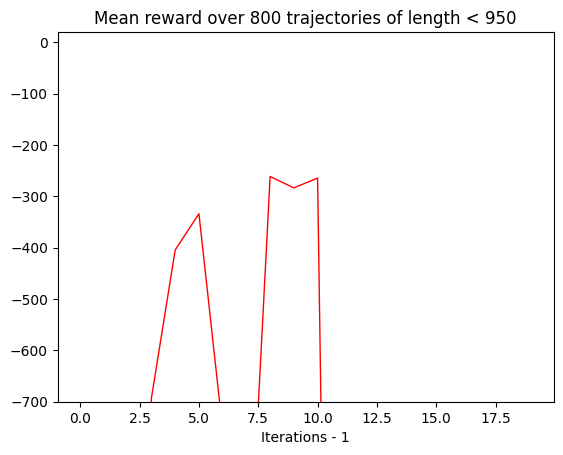

In [14]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True, n_jobs=4)

In [294]:
study.best_params
# plot_intermediate_values(study)

{'n_trajectories': 700, 'max_length': 950, 'q': 0.7, 'lr': 0.8}

In [370]:
ce_agent_lr = CrossEntropyAgent(N_STATES, N_ACTIONS, ACTIONS_STR)
besthp = {'n_trajectories': 700, 'max_length': 950, 'q': 0.7, 'lr': 0.8}
# ce_agent.get_policy() # uniform policy matrix

5.535714285714286

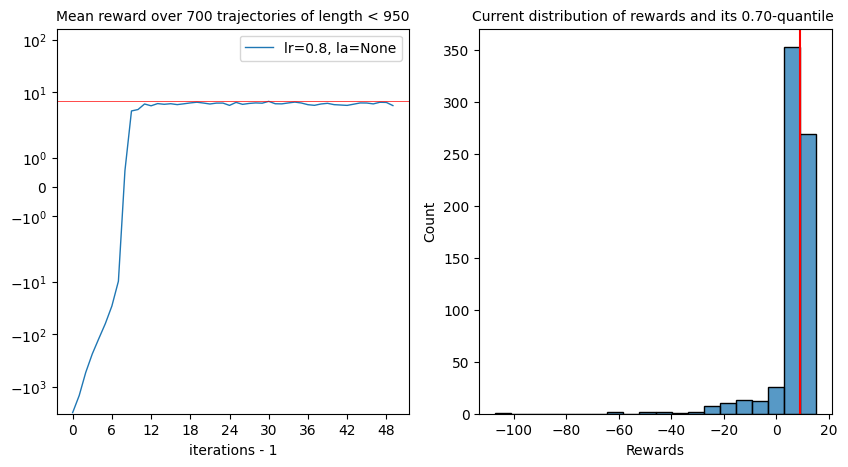

In [371]:
ce_agent_lr.fit(n_iterations=50, **besthp, verbose=1)

In [362]:
def explore(vrange=(0.5, 0.9, 0.1), mode='lr'):
    ax = ce_agent_base.learning_curve(show_max=True)
    hp = {'n_trajectories': 700, 'max_length': 950, 'q': 0.7}
    for v in np.arange(*vrange):
        try:
            hp[mode] = v
        except KeyError:
            break
            return 'wrong hyperparameter'
        ce_agent = CrossEntropyAgent(N_STATES, N_ACTIONS, ACTIONS_STR)
        ce_agent.fit(n_iterations=50, **hp, verbose=False)
        ax = ce_agent.learning_curve(ax=ax, show_max=False)
        display.display(plt.gcf())
        display.clear_output(wait=True)

In [367]:
# explore(vrange=(0.0001, 0.001, 0.0001), mode='la')

## Experiments with exponential smoothing (lr) within range (0.1, 1.0, 0.05)

As usual, larger learning rate results in faster but unstable convergence

Nevertheless, even highest learning rate lr=0.99999 doesn't break convergence 

Idea: we should use adaptive (and descending) learning rate as we don't care about stability initially

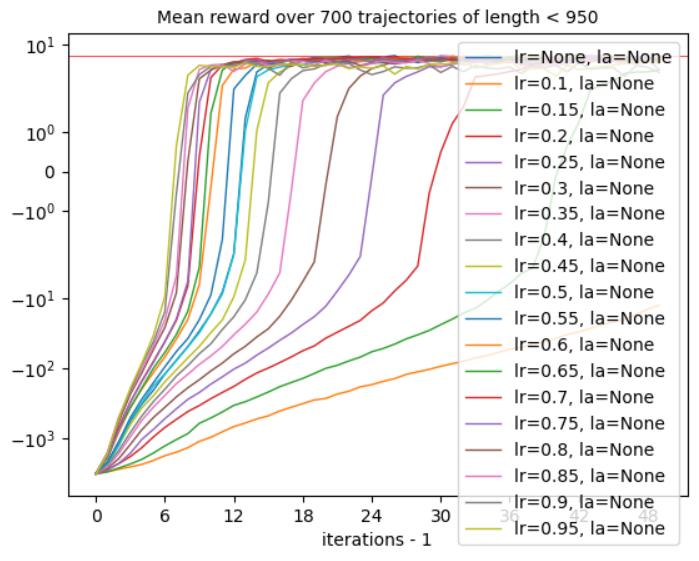

Note that lr=0.5 (obviously) corresponds to our base case with lr=None

## Experiments with Laplacian smoothing

Completely useless, even with la=0.001 converges poorly and to much lower value

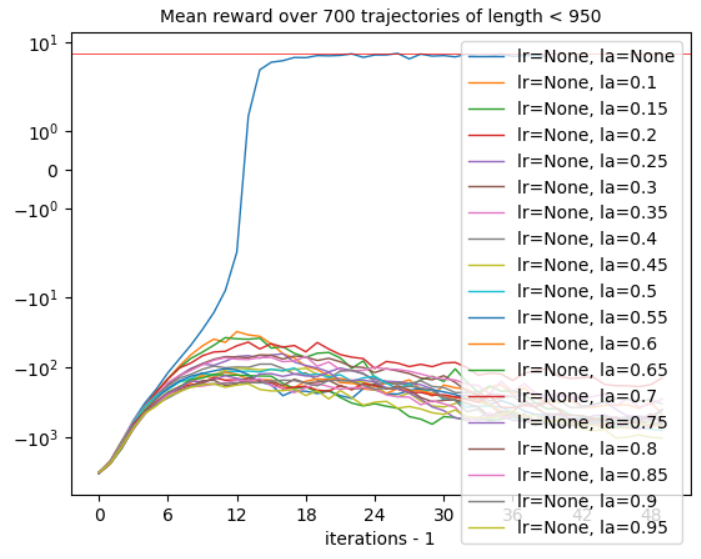

Experiments with deterministic sampling

ce_agent.sample_dp() samples n_det deterministic policies from current ce_agent.sa.
I managed to vectorize and use inverse transform for uniform vector instead of np.random.choice by row

It doesn't break convergence but it's unstable and the rate of convergence is still extremely low (n_det=10)
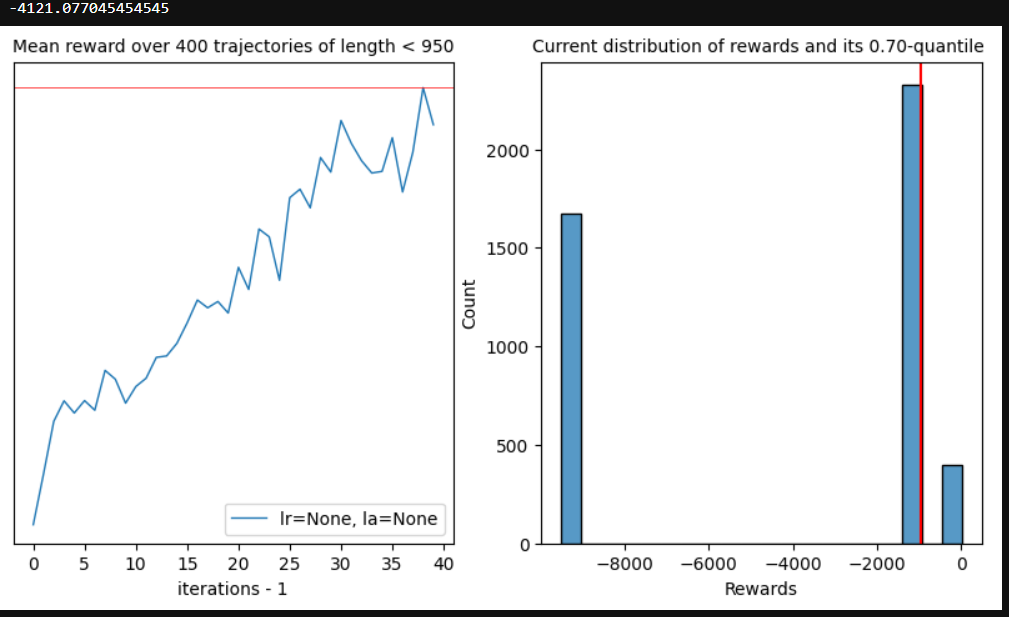

It doesn't even help if n_det=100, q=0.5 and n_trajectories=100 (10K trajectories per iteration in total and lots of information could be retrieved thanks to q=0.5)
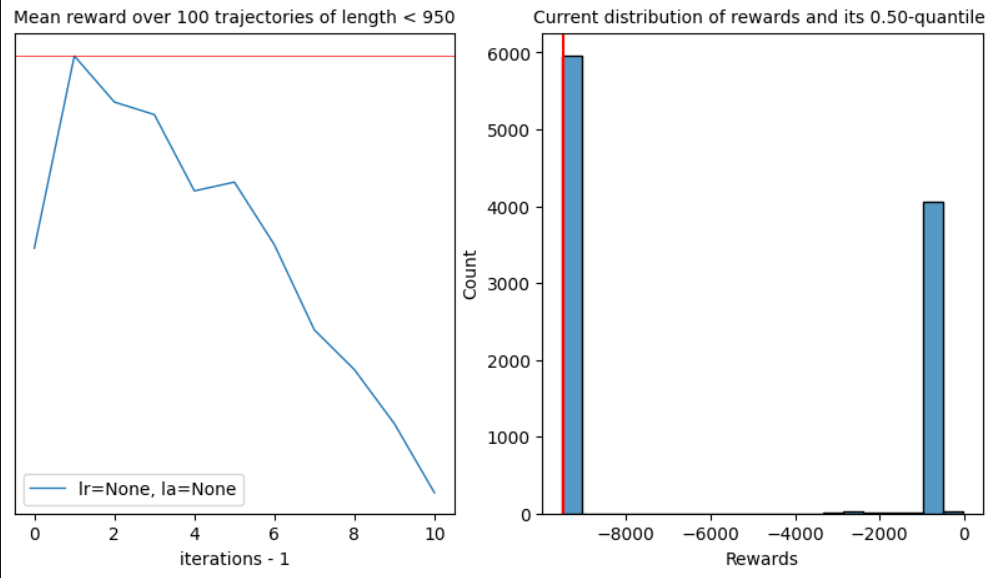

In [ ]:
ce_agent_base.sample_dp()